In [1]:
!pip install yfinance

     |████████████████████████████████| 63 kB 1.3 MB/s 
     |████████████████████████████████| 6.4 MB 9.9 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import yfinance as yf

In [4]:
# HTML에 있는 table속성에 해당하는 값 가져오기
tickers = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[0]["Symbol"]

[*********************100%***********************]  1 of 1 completed
MMM


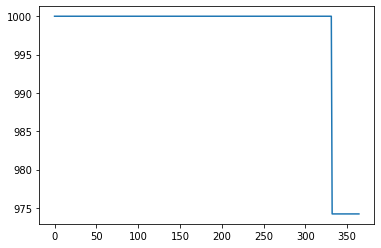

investing total: 894.3870684086265 -10.6%
Algo-Trading Total: 974.2226289954576 -2.6%
[*********************100%***********************]  1 of 1 completed
AOS


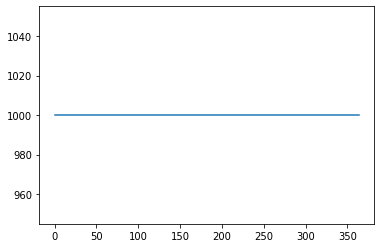

investing total: 1193.9962532944705 19.4%
Algo-Trading Total: 1000 0.0%
[*********************100%***********************]  1 of 1 completed
ABT


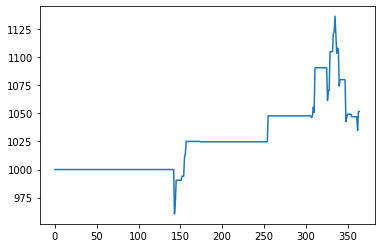

investing total: 1081.6904415578338 8.2%
Algo-Trading Total: 1051.7133807755183 5.2%
[*********************100%***********************]  1 of 1 completed
ABBV


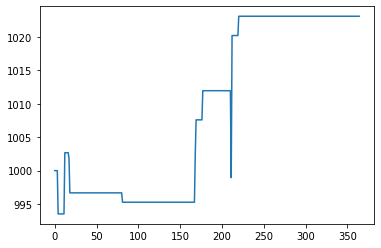

investing total: 1831.855376654521 83.2%
Algo-Trading Total: 1023.0923635273991 2.3%
[*********************100%***********************]  1 of 1 completed
ABMD


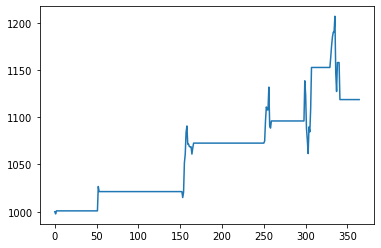

investing total: 1178.9877103554059 17.9%
Algo-Trading Total: 1118.7553419742292 11.9%
[*********************100%***********************]  1 of 1 completed
ACN


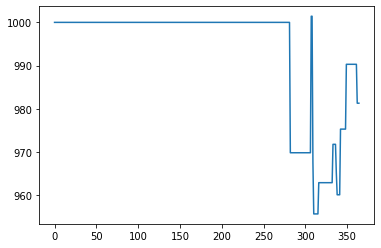

investing total: 1431.8373059297542 43.2%
Algo-Trading Total: 981.2825123747162 -1.9%
[*********************100%***********************]  1 of 1 completed
ATVI


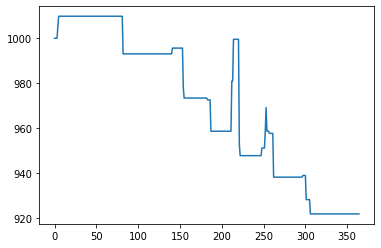

investing total: 1030.815609864829 3.1%
Algo-Trading Total: 922.002201922137 -7.8%
[*********************100%***********************]  1 of 1 completed
ADM


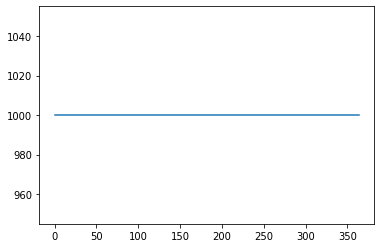

investing total: 1993.5282348910519 99.4%
Algo-Trading Total: 1000 0.0%
[*********************100%***********************]  1 of 1 completed
ADBE


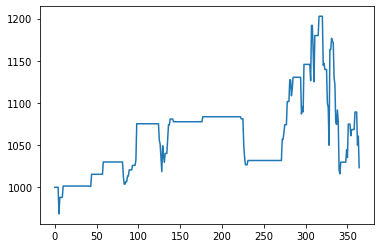

investing total: 937.1173329725158 -6.3%
Algo-Trading Total: 1023.267539375464 2.3%
[*********************100%***********************]  1 of 1 completed
ADP


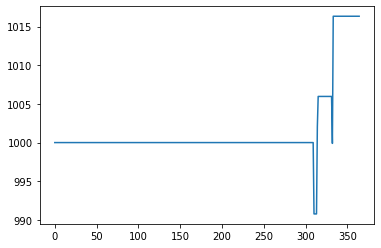

investing total: 1394.0412814046886 39.4%
Algo-Trading Total: 1016.3472875668199 1.6%


In [19]:
from sklearn.linear_model import LinearRegression

def test_it(opens, closes, preds, start_account=1000, thresh=0):
    account = start_account
    changes = []

    for i in range(len(preds)):
        if (preds[i] - opens[i]) / opens[i] >= thresh:
            account += account * (closes[i] - opens[i]) / opens[i]
        changes.append(account)

    changes = np.array(changes)

    plt.plot(range(len(changes)), changes)
    plt.show()

    invest_total = start_account + start_account * (closes[-1] - opens[0]) / closes[0]
    print("investing total:", invest_total, str(round((invest_total - start_account) / start_account * 100,1)) + "%")
    print("Algo-Trading Total:", account, str(round((account - start_account) / start_account * 100,1)) + "%")

def calc_macd(data, len1, len2, len3):
    shortEMA = data.ewm(span=len1, adjust=False).mean()
    longEMA = data.ewm(span=len2, adjust=False).mean()
    MACD = shortEMA - longEMA
    signal = MACD.ewm(span=len3, adjust=False).mean()
    return MACD, signal

def calc_rsi(data, period):
    delta = data.diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ema_up = up.ewm(com=period, adjust=False).mean()
    ema_down = down.ewm(com=period, adjust=False).mean()
    rs = ema_up / ema_down
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calc_bollinger(data, period):
    mean = data.rolling(period).mean()
    std = data.rolling(period).std()
    upper_band = np.array(mean) + 2 * np.array(std)
    lower_band = np.array(mean) - 2 * np.array(std)
    return upper_band, lower_band

for ticker in tickers[0:10]:
    end_date = datetime.now()
    start_date = end_date - timedelta(days=15*365)

    history = yf.download(ticker, start=start_date, end=end_date, interval="1d", prepost=False)
    history = history.loc[:, ["Open", "Close", "Volume"]]

    history["Prev_Close"] = history.loc[:, "Close"].shift(1)
    history["Prev_Volume"] = history.loc[:, "Volume"].shift(1)

    datetimes = history.index.values
    weekdays = []

    # strftime: datetiem 데이터를 문자열로 출력
    # strptime: 날짜 형식의 문자열을 datetime으로 변환
    for dt in datetimes:
        dt = datetime.strptime(str(dt), "%Y-%m-%dT%H:%M:%S.000000000")        
        # 0:월요일
        weekdays.append(dt.weekday())

    history["weekday"] = weekdays

    history["5SMA"] = history["Prev_Close"].rolling(5).mean()
    history["10SMA"] = history["Prev_Close"].rolling(10).mean()
    history["20SMA"] = history["Prev_Close"].rolling(20).mean()
    history["50SMA"] = history["Prev_Close"].rolling(50).mean()
    history["100SMA"] = history["Prev_Close"].rolling(100).mean()
    history["200SMA"] = history["Prev_Close"].rolling(200).mean()

    MACD, signal = calc_macd(history["Prev_Close"], 12, 26, 9)
    history["MACD"] = MACD
    history["MACD_signal"] = signal

    history["RSI"] = calc_rsi(history["Prev_Close"], 13)
    history["RSI_Volume"] = calc_rsi(history["Prev_Volume"], 13)

    upper, lower = calc_bollinger(history["Prev_Close"], 20)
    history["Upper_Band"] = upper
    history["Lower_Band"] = lower

    labels = ["Prev_Close", "Prev_Volume", "5SMA", "10SMA", "20SMA", "50SMA", "100SMA", "200SMA", "MACD", "MACD_signal", "RSI", "RSI_Volume", "Upper_Band", "Lower_Band"]

    period = 1
    new_labels = [str(period) + "d_" + label for label in labels]
    history[new_labels] = history[labels].pct_change(period, fill_method="ffill")
    # print(new_labels)

    period = 2
    new_labels = [str(period) + "d_" + label for label in labels]
    history[new_labels] = history[labels].pct_change(period, fill_method="ffill")

    period = 5
    new_labels = [str(period) + "d_" + label for label in labels]
    history[new_labels] = history[labels].pct_change(period, fill_method="ffill")

    period = 10
    new_labels = [str(period) + "d_" + label for label in labels]
    history[new_labels] = history[labels].pct_change(period, fill_method="ffill")

    history = history.replace(np.inf, np.nan).dropna()


    y = history["Close"]
    X = history.drop(["Close", "Volume"], axis=1).values

    num_test = 365
    X_train = X[:-1 * num_test]
    y_train = y[:-1 * num_test]
    X_test = X[-1 * num_test:]
    y_test = y[-1 * num_test:]

    # print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

    model = LinearRegression()
    model = model.fit(X_train, y_train)
    preds = model.predict(X_test)

    print(ticker)
    # plt.figure(figsize=(15,5))
    # plt.plot(range(len(y_test)), y_test, "blue")
    # plt.plot(range(len(preds)), preds, "red")

    test_it(X_test.T[0], y_test, preds, 1000, 0.005)


    """
    x = history.index.values

    plt.figure(figsize=(15,5))
    plt.plot(x, history["Prev_Close"], color="blue")
    # plt.plot(x, history["5SMA"], color="orange")
    # plt.plot(x, history["10SMA"], color="green")
    # plt.plot(x, history["20SMA"], color="pink")
    plt.plot(x, history["50SMA"], color="purple")
    # plt.plot(x, history["100SMA"], color="cyan")
    plt.plot(x, history["200SMA"], color="red")
    plt.plot(x, history["Upper_Band"], color="orange")
    plt.plot(x, history["Lower_Band"], color="orange")
    # plt.xlim(x[1000], x[1500])
    plt.show()

    plt.figure(figsize=(15,5))
    colors = np.array(["green"]*len(history["MACD"]))
    colors[history["MACD"]<0] = "red"
    plt.bar(x, history["MACD"], color=colors)
    plt.plot(x, history["MACD_signal"], color="blue")
    plt.xlim(x[1000], x[1500])
    plt.show()

    plt.figure(figsize=(15,5))    
    plt.plot(x, history["RSI"], color="purple")
    plt.plot([x[0], x[-1]], [80, 80], color="red")
    plt.plot([x[0], x[-1]], [20, 20], color="green")
    plt.xlim(x[1000], x[1500])
    plt.ylim(0,100)
    plt.show()

    display(history)
    """


MMM


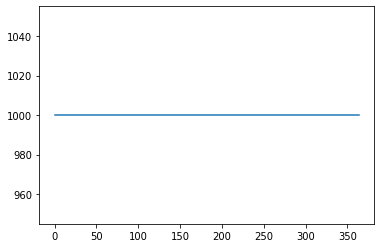

investing total: 894.3870684086265 -10.6%
Algo-Trading Total: 1000 0.0%


In [15]:
from sklearn.linear_model import LinearRegression

def test_it(opens, closes, preds, start_account=1000, thresh=0):
    account = start_account
    changes = []

    for i in range(len(preds)):
        if (preds[i] - opens[i]) / opens[i] >= thresh:
            account += account * (closes[i] - opens[i]) / opens[i]
        changes.append(account)

    changes = np.array(changes)

    plt.plot(range(len(changes)), changes)
    plt.show()

    invest_total = start_account + start_account * (closes[-1] - opens[0]) / closes[0]
    print("investing total:", invest_total, str(round((invest_total - start_account) / start_account * 100,1)) + "%")
    print("Algo-Trading Total:", account, str(round((account - start_account) / start_account * 100,1)) + "%")

y = history["Close"]
X = history.drop(["Close", "Volume"], axis=1).values

num_test = 365
X_train = X[:-1 * num_test]
y_train = y[:-1 * num_test]
X_test = X[-1 * num_test:]
y_test = y[-1 * num_test:]

# print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

model = LinearRegression()
model = model.fit(X_train, y_train)
preds = model.predict(X_test)

print(ticker)
# plt.figure(figsize=(15,5))
# plt.plot(range(len(y_test)), y_test, "blue")
# plt.plot(range(len(preds)), preds, "red")

test_it(X_test.T[0], y_test, preds, 1000, 0.05)